In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import re

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', 0)

In [2]:
DOMAIN="clinical"

def replace_quotation(el):
    try:
        return json.loads(el)
    except:
        el = el.replace("\'", '"')
        
def load_csv(csv_path):
    df = pd.read_csv(csv_path).query(f"domain=='{DOMAIN}'").reset_index(drop=True)
    df.loc[:, "medical_entities"] =  df.loc[:, "detect_entities"].apply(lambda x: replace_quotation(x))
    return df

In [3]:
csv_path="../NER/entities/full_intron-train-public-58000-clean_with_entities.csv"
df_train = load_csv(csv_path)

csv_path="../NER/entities/full_intron-dev-public-3231-clean_with_entities.csv"
df_dev = load_csv(csv_path)

csv_path="../NER/entities/full_intron-test-public-6346-clean_with_entities.csv"
df_test = load_csv(csv_path)

print(len(df_train), len(df_dev), len(df_test))

36318 1824 3623


In [4]:
df_test.head(1)

,Unnamed: 0,idx,user_ids,accent,age_group,country,transcript,nchars,audio_ids,audio_paths,duration,origin,domain,split,gender,detect_entities,detect_phi,medical_entities
0,0,149716,5ab7b49ad1cab6392a764a69578dc822,twi,26-40,GH,Proteins break down to release amino acids which are used as fuel for hepatic gluconeogenesis to maintain the glucose needs of the brain.,136,3a21d00eec39a31f089b9b4f0f8afa21,/AfriSpeech-100/test/e696aff8-ce05-4c8e-a3b3-5634f3da50b9/3b55a5d83ae194039127818b59e5b78a.wav,10.776984,african,clinical,test,Female,"{\n ""Entities"": [\n {\n ""Id"": 1,\n ""BeginOffset"": 131,\n ""EndOffset"": 136,\n ""Score"": 0.9999834299087524,\n ""Text"": ""brain"",\n ""Category"": ""ANATOMY"",\n ""Type"": ""SYSTEM_ORGAN_SITE"",\n ""Traits"": []\n }\n ],\n ""UnmappedAttributes"": [],\n ""ModelVersion"": ""2.3.0""\n}\n","{\n ""Entities"": [],\n ""ModelVersion"": ""1.1.0""\n}\n","{'Entities': [{'Id': 1, 'BeginOffset': 131, 'EndOffset': 136, 'Score': 0.9999834299087524, 'Text': 'brain', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}"


In [5]:
df_test.accent.value_counts()

accent
yoruba     270
swahili    227
igbo       194
hausa      144
english    104
          ... 
bette      3  
nembe      3  
nupe       2  
ikwere     2  
afemai     1  
Name: count, Length: 95, dtype: int64

In [6]:
df_train.domain.value_counts(), df_dev.domain.value_counts(), df_test.domain.value_counts()

(domain
 clinical    36318
 Name: count, dtype: int64,
 domain
 clinical    1824
 Name: count, dtype: int64,
 domain
 clinical    3623
 Name: count, dtype: int64)

In [7]:
df_train = df_train[~df_train.duplicated("idx")]
df_dev = df_dev[~df_dev.duplicated("idx")]
df_test = df_test[~df_test.duplicated("idx")]

In [8]:
# Total clinical domain clips
len(df_train), len(df_dev), len(df_test)

(36318, 1824, 3623)

In [9]:
# Averaged duration
df_train.duration.sum() /3600, df_dev.duration.sum() /3600, df_test.duration.sum() /3600

(109.81832497480474, 4.757048337112623, 10.598889758125473)

In [10]:
# Number of accents
len(df_train.accent.value_counts()), len(df_dev.accent.value_counts()), len(df_test.accent.value_counts())

(69, 39, 95)

In [11]:
# Number of speaker
len(df_train.user_ids.value_counts()), len(df_dev.user_ids.value_counts()), len(df_test.user_ids.value_counts())

(1095, 166, 468)

In [12]:
# Averaged speakers per accent
for df in [df_train, df_dev, df_test]:
    print(df.groupby(['accent']).apply(lambda x: len(set(x['user_ids']))).values.mean())

15.869565217391305
4.256410256410256
4.926315789473684


In [13]:
# Averaged clips per speaker
for df in [df_train, df_dev, df_test]:
    print(df.groupby(['user_ids']).apply(lambda x: len(set(x['audio_ids']))).values.mean())

33.16712328767123
10.987951807228916
7.72008547008547


In [14]:
len(df_train.country.value_counts()), len(df_dev.country.value_counts()), len(df_test.country.value_counts())

(10, 9, 10)

In [15]:
def get_entities_values(df, attribute="Score"):
    values = []
    for i in range(len(df)):
        entities = df["medical_entities"][i]
        if entities is not None:
            entities = entities["Entities"]
            for j in range(len(entities)):
                values.append(entities[j][attribute])
    return values

In [16]:
categories = list(set(get_entities_values(df_test, attribute="Category")))

# make sure the entities categories are the same for train and test
assert set(set(get_entities_values(df_train, attribute="Category"))) == set(categories)
categories

['TIME_EXPRESSION',
 'MEDICATION',
 'BEHAVIORAL_ENVIRONMENTAL_SOCIAL',
 'TEST_TREATMENT_PROCEDURE',
 'MEDICAL_CONDITION',
 'PROTECTED_HEALTH_INFORMATION',
 'ANATOMY']

We're only focusing on four categories for this project
- MEDICATION
- MEDICAL_CONDITION
- ANATOMY
- PROTECTED_HEALTH_INFORMATION

In [17]:
VALID_CATEGORIES = ["MEDICATION", "MEDICAL_CONDITION", 
                    "ANATOMY", "PROTECTED_HEALTH_INFORMATION",
                   "TEST_TREATMENT_PROCEDURE"]
VALID_CATEGORIES_COUNT = ["MEDICATION_count", "MEDICAL_CONDITION_count", 
                          "ANATOMY_count", "PROTECTED_HEALTH_INFORMATION_count",
                         "TEST_TREATMENT_PROCEDURE_count"]

,scores_train
count,97349.000000
mean,0.851239
std,0.186356
min,0.052329
25%,0.730901
50%,0.950973
75%,0.997645
max,1.000000


,scores_test
count,9146.000000
mean,0.852707
std,0.186175
min,0.098740
25%,0.729393
50%,0.954385
75%,0.997776
max,1.000000


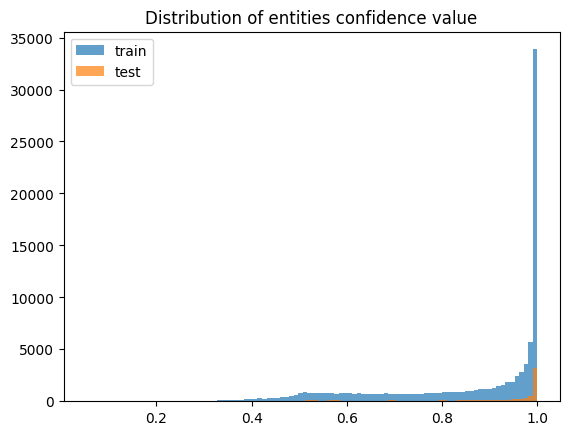

In [18]:
scores_train =  get_entities_values(df_train, attribute="Score")
display(pd.DataFrame(scores_train, columns=["scores_train"]).describe())

scores_test =  get_entities_values(df_test, attribute="Score")
display(pd.DataFrame(scores_test, columns=["scores_test"]).describe())

_ = plt.hist(scores_train, bins=100, label="train", alpha=0.7)
_ = plt.hist(scores_test, bins=100, label="test", alpha=0.7)

plt.legend()
_ = plt.title("Distribution of entities confidence value")

## Check if categories scores are calibrated to be within the same range

In [19]:
def scores_per_category(df):
    medical_entities = df.medical_entities
    scores_dict = {}
    
    for el in medical_entities:
        if el is not None:
            entities = el["Entities"]
            for entity in entities:
                text = entity["Text"]
                category = entity["Category"]
                score = entity["Score"]
                if scores_dict.get(category) is None:
                    scores_dict[category] = [score]
                else:
                    scores_dict[category].append(score)
    return scores_dict

scores_per_cat = scores_per_category(df_train)
for k in scores_per_cat.keys():
    print(f"Scores for {k}")
    print(f"Min value: {round(min(scores_per_cat[k]), 3)}", f"Max value: {round(max(scores_per_cat[k]), 3)}")
    

Scores for MEDICAL_CONDITION
Min value: 0.265 Max value: 1.0
Scores for ANATOMY
Min value: 0.25 Max value: 1.0
Scores for TIME_EXPRESSION
Min value: 0.312 Max value: 1.0
Scores for TEST_TREATMENT_PROCEDURE
Min value: 0.156 Max value: 1.0
Scores for BEHAVIORAL_ENVIRONMENTAL_SOCIAL
Min value: 0.253 Max value: 1.0
Scores for PROTECTED_HEALTH_INFORMATION
Min value: 0.052 Max value: 1.0
Scores for MEDICATION
Min value: 0.207 Max value: 1.0


### Get transcripts per category for different score ranges

In [20]:
def get_transcript_per_category(df, category, min_range, max_range):
    medical_entities = df.medical_entities
    idxs = []
    texts = []
    scores = []
    
    for idx, el in enumerate(medical_entities):
        if el is not None:
            entities = el["Entities"]
            for entity in entities:
                score = entity["Score"]
                if entity["Category"] == category and  (min_range <= score and max_range >= score):
                    idxs.append(idx)
                    texts.append(entity["Text"])
                    scores.append(score)
    df = df.iloc[idxs]
    df.loc[:, "category"] = [category]*len(df)
    df.loc[:, "text"] = texts
    df.loc[:, "score"] = scores
    return df

In [21]:
def transcript_per_category_range(df, n=1, min_range=0, max_range=1, random_state=42):
    out_df = []
    for category in VALID_CATEGORIES:
        out = get_transcript_per_category(df, category=category, min_range=min_range, max_range=max_range)
        if len(out) > n:
            out_df.append(out[["transcript", "category", "text", "score"]].sample(n, random_state=random_state))
        else:
            out_df.append(out[["transcript", "category", "text", "score"]].head(n))

    out_df = pd.concat(out_df).sort_values(["category", "score"], ascending=True)
    return out_df

In [22]:
min_range=0
max_range=0.3
random_state=42
n=1

transcript_per_category_range(df_train, n=n, min_range=min_range, max_range=max_range, random_state=random_state)

,transcript,category,text,score
25012,"Laceration of muscle, fascia and tendon of other parts of biceps, left. INJECTABLE, INJECTION BREVIBLOC, ESMOLOL HYDROCHLORIDE, 20MG/ML. Other physeal fracture of upper end of humerus, right arm, subsequent",ANATOMY,end,0.274194
5091,Cryptorchidism is unilateral in 80 cases and bilateral in the rest.,MEDICAL_CONDITION,Cryptorchidism,0.276265
602,"This cycle is interrupted by warfarin, which is structurally closely related to vitamin K, and inhibits vitamin K epoxide reductase.",MEDICATION,epoxide,0.244587
2765,They asked appropriate questions and spoke lovingly to Maigero.,PROTECTED_HEALTH_INFORMATION,Maigero,0.141019
2869,Elevate the wrapped extremity for 15 to 30 minutes after application of the bandage.,TEST_TREATMENT_PROCEDURE,Elevate the wrapped extremity,0.283143


In [23]:
min_range=0.4
max_range=0.6
random_state=42
n=1

transcript_per_category_range(df_train, n=n, min_range=min_range, max_range=max_range, random_state=random_state)

,transcript,category,text,score
26469,"Contusion of thorax, unspecified, subsequent encounter. TABLET, ORAL GLYBURIDE (MICRONIZED), GLYBURIDE, 1.5MG. Drowning and submersion after fall into bathtub, undetermined intent,",ANATOMY,thorax,0.541585
14960,"A variant of chronic pancreatitis is a non-obstructive, diffusely infiltrative disease associated with fibrosis, a mononuclear cell lymphocyte, plasma cell, or eosinophil infiltrate, and an increased titer of one or more auto-antibodies.",MEDICAL_CONDITION,chronic pancreatitis,0.506214
23941,"Type 2 diabetes mellitus with proliferative diabetic retinopathy with. INJECTABLE, INJECTION NICARDIPINE HYDROCHLORIDE, NICARDIPINE HYDROCHLORIDE, 25MG/10ML (2.5MG/ML). Unspecified subluxation of left sternoclavicular joint, subsequent enc",MEDICATION,HYDROCHLORIDE,0.519342
32662,4O/A-Mom and dad Annoh with pleasure of successful latching on.,PROTECTED_HEALTH_INFORMATION,4O,0.525669
1785,CHEST PORTABLE AP Reason: s/p cardiac arrest CV line placement acute MI,TEST_TREATMENT_PROCEDURE,CV line placement,0.419499


In [24]:
min_range=0.8
max_range=1.0
random_state=42
n=1

transcript_per_category_range(df_train, n=n, min_range=min_range, max_range=max_range, random_state=random_state)

,transcript,category,text,score
12540,"The patient had a CT scan, which revealed a mass in the gallbladder neck, but no biliary dilatation .",ANATOMY,gallbladder neck,0.997106
20150,No systemic adverse effects of ribavirin have been reported following administration by aerosol or nebulizer.,MEDICAL_CONDITION,systemic adverse effects of ribavirin,0.847955
36247,"Nondisplaced avulsion fracture (chip fracture) of right talus, sequela. FOR SUSPENSION, ORAL E-Z-EM PREP LYTE, POLYETHYLENE GLYCOL 3350; POTASSIUM CHLORIDE; SODIUM BICARBONATE; SODIUM CHLORIDE; SODIUM SULFATE ANHYDROUS, 236GM/BOT;2.97GM/BOT;6.74GM/BOT;5.86GM/BOT;22.74GM/BOT. Lead-induced chronic gout, left knee, with tophus (tophi)",MEDICATION,POTASSIUM CHLORIDE,0.802842
7642,Lippincott Company 6th edition 1994 4.,PROTECTED_HEALTH_INFORMATION,1994,0.929802
14041,-No issues -High A-fib risk aggressive Mg/ Ca replacement telemetry -F/u cardiac enzymes Pulmonary: -S/p tracheoplasty extubated comfortable -BAL positive for GNR and GPC speciation pending started on Levaquin will watch speciation Gastrointestinal: Stable Renal:,TEST_TREATMENT_PROCEDURE,BAL,0.843859


### Set Score threshold

In [25]:
SCORE_THRESHOLD=0.0

### Remove NaN entities

In [26]:
# remove nan instances
df_test = df_test[~df_test["medical_entities"].isna()]
df_train = df_train[~df_train["medical_entities"].isna()]
df_dev = df_dev[~df_dev["medical_entities"].isna()]

### Apply clean_text function on transcript

In [27]:
def clean_text(text):
    """
    post processing to normalized reference and predicted transcripts
    :param text: str
    :return: str
    """
    # remove multiple spaces
    text = re.sub(r"\s\s+", " ", text)
    # strip trailing spaces
    text = text.strip()
    
    text = text.replace('>', '')
    text = text.replace('\t', ' ')
    text = text.replace('\n', '')
    text = text.lower()
    text = text.replace(" comma,", ",") \
        .replace(" koma,", " ") \
        .replace(" koma ", " ") \
        .replace(" coma,", " ") \
        .replace(" full stop.", ".") \
        .replace(" full stop", ".") \
        .replace(",.", ".") \
        .replace(",,", ",") \
        .strip()
    
#     text = " ".join(text.split())
    text = re.sub(r"[^a-zA-Z0-9\s\.\,\-\?\:\'\/\(\)\[\]\+\%]", '', text)
    return text

In [28]:
df_test["transcript_original"] = df_test["transcript"]
df_test["transcript"] = df_test.transcript.apply(lambda x: clean_text(x) if type(x) == str else "")

df_train["transcript_original"] = df_train["transcript"]
df_train["transcript"] = df_train.transcript.apply(lambda x: clean_text(x) if type(x) == str else "")


df_dev["transcript_original"] = df_dev["transcript"]
df_dev["transcript"] = df_dev.transcript.apply(lambda x: clean_text(x) if type(x) == str else "")

In [29]:
df_train.query("idx==638859")["transcript_original"]

16499    A: hemodynamically stable stable resp status tolerating ^ activity continued altered ms.
Name: transcript_original, dtype: object

In [30]:
df_train.query("idx==638859")["transcript"]

16499    a: hemodynamically stable stable resp status tolerating  activity continued altered ms.
Name: transcript, dtype: object

### Extract Entities
We will only focus on the test set

In [31]:
# find character that can be used to join the texts
candidate_char = ["_", " ", "-", ";"]
all_chars_in_transcript = set("".join(list(df_test["transcript"].values)))

JOIN_CHAR = None

for char in candidate_char:
    if char in all_chars_in_transcript:
        continue
    else:
        JOIN_CHAR = char
        break

if JOIN_CHAR is None:
    JOIN_CHAR = ""
    
print(JOIN_CHAR)

_


In [32]:
def concat_all_entities(row):
    transcript = row['transcript'].lower()
    el = row["medical_entities"]
    entities = el["Entities"]
    texts = []
    
    for entity in entities:
        
        text = entity["Text"].lower().rstrip("")
        score = entity["Score"]
        entity_category = entity["Category"]

        if entity_category in VALID_CATEGORIES and score >= SCORE_THRESHOLD:
            # we want to avoid single character matches
            if len(text) > 1:
                text= clean_text(text)
#                 text_index = transcript.index(text)
                try:
                    text_index = transcript.index(text)
#                     texts.append(text.lower())
                
                except Exception as e:
                    print(f"---Exception: {e}")
                    print(f"Entity: {text}")
                    print(f"Transcript: {transcript}")
                    print(f"Index: {row['idx']}")
#                     # manually found exceptions
#                     if text == "paino":
#                         text = text.replace('paino', 'pain')
#                     elif text == "began stating i can't breath":
#                         text = text.replace("began stating i can't breath", "began stating ""i can't breath")
#                     else:
                    raise e
                texts.append(text.lower())
                    
    return f"{JOIN_CHAR}".join(texts)

# These two functions could be merged. 
# They were separated for ease of readability and debugging purposes
def concat_entities(row, category):
    el = row["medical_entities"]
    entities = el["Entities"]
    texts = []
    for entity in entities:
        text = entity["Text"].lower().rstrip("")
        score = entity["Score"]
        entity_category = entity["Category"]

        if category == entity_category and category in VALID_CATEGORIES and score >= SCORE_THRESHOLD:
            if len(text) > 1:
                text= clean_text(text)
                # apply entities corrected in previous step
#                 if text == "paino":
#                     text = text.replace('paino', 'pain')
                
                texts.append(text)

    return f"{JOIN_CHAR}".join(texts)

def count_entities(row, category=None):
    el = row["medical_entities"]
    entities = el["Entities"]
    count = 0
    for entity in entities:
        text = entity["Text"]
        text = text.rstrip("")
        score = entity["Score"]
        entity_category = entity["Category"]

        if category == entity_category and category in VALID_CATEGORIES and score >= SCORE_THRESHOLD:
            if len(text) > 1:
                count += 1
    return count

In [33]:
df_test.query("idx == 157408")["transcript_original"]

732    Acute intoxication can occur consisting of restlessness, anxiety, confusion, tachycardia, angina, cardiovascular collapse, convulsions, coma and death.
Name: transcript_original, dtype: object

In [34]:
df_test["cat_entities"] = df_test.apply(lambda x: concat_all_entities(x), axis=1)

In [35]:
df_dev["cat_entities"] = df_dev.apply(lambda x: concat_all_entities(x), axis=1)

In [36]:
df_train["cat_entities"] = df_train.apply(lambda x: concat_all_entities(x), axis=1)

In [37]:
for category in VALID_CATEGORIES:
    df_test[category] = df_test.apply(lambda x: concat_entities(x, category), axis=1)
    df_train[category] = df_train.apply(lambda x: concat_entities(x, category), axis=1)
    df_dev[category] = df_dev.apply(lambda x: concat_entities(x, category), axis=1)

In [38]:
for category in VALID_CATEGORIES:
    df_test[f"{category}_count"] = df_test.apply(lambda x: count_entities(x, category), axis=1)
    df_train[f"{category}_count"] = df_train.apply(lambda x: count_entities(x, category), axis=1)
    df_dev[f"{category}_count"] = df_dev.apply(lambda x: count_entities(x, category), axis=1)

In [39]:
df_test[["cat_entities", *VALID_CATEGORIES]]

,cat_entities,MEDICATION,MEDICAL_CONDITION,ANATOMY,PROTECTED_HEALTH_INFORMATION,TEST_TREATMENT_PROCEDURE
0,brain,,,brain,,
1,grant_patent against the party,,patent against the party,,grant,
2,peristalsis,,peristalsis,,,
3,,,,,,
4,,,,,,
...,...,...,...,...,...,...
3618,fracture_proximal phalanx_finger_muscle_tendon_long extensor muscle_toe,,fracture,proximal phalanx_finger_muscle_tendon_long extensor muscle_toe,,
3619,cabg_myocardial infarction,,myocardial infarction,,,cabg
3620,bacitracin zinc,bacitracin zinc,,,,
3621,blood culture_blood cultures,,,,,blood culture_blood cultures


In [40]:
for category in VALID_CATEGORIES:
    df_test[f"{category}_count"] = df_test.apply(lambda x: count_entities(x, category), axis=1)
    df_train[f"{category}_count"] = df_train.apply(lambda x: count_entities(x, category), axis=1)
    df_dev[f"{category}_count"] = df_dev.apply(lambda x: count_entities(x, category), axis=1)

In [41]:
df_test[df_test.idx==481459]["cat_entities"]

2049    sepsiss_paino_cardiac_sr_atrial_ventricular_arrythymias
Name: cat_entities, dtype: object

In [42]:
df_test[["domain", "transcript", "medical_entities", "cat_entities"]].sample(1)

,domain,transcript,medical_entities,cat_entities
2592,clinical,a ammooay mom p continue update and teaching.,"{'Entities': [], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",


In [43]:
df_test[["domain", "transcript", "medical_entities", "cat_entities", *VALID_CATEGORIES]].sample(1)

,domain,transcript,medical_entities,cat_entities,MEDICATION,MEDICAL_CONDITION,ANATOMY,PROTECTED_HEALTH_INFORMATION,TEST_TREATMENT_PROCEDURE
2078,clinical,current exam: t 99 hr 95 sinus bp 103/53 rr,"{'Entities': [{'Id': 1, 'BeginOffset': 0, 'EndOffset': 7, 'Score': 0.9999986886978149, 'Text': 'Current', 'Category': 'TIME_EXPRESSION', 'Type': 'TIME_TO_TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_NAME', 'Score': 0.8476978540420532, 'RelationshipScore': 0.5706944465637207, 'RelationshipType': 'OVERLAP', 'Id': 9, 'BeginOffset': 41, 'EndOffset': 43, 'Text': 'RR', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}]}, {'Id': 1, 'BeginOffset': 0, 'EndOffset': 7, 'Score': 0.9999986886978149, 'Text': 'Current', 'Category': 'TIME_EXPRESSION', 'Type': 'TIME_TO_TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_NAME', 'Score': 0.8464603424072266, 'RelationshipScore': 0.7630650401115417, 'RelationshipType': 'OVERLAP', 'Id': 3, 'BeginOffset': 14, 'EndOffset': 15, 'Text': 'T', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}]}, {'Id': 1, 'BeginOffset': 0, 'EndOffset': 7, 'Score': 0.9999986886978149, 'Text': 'Current', 'Category': 'TIME_EXPRESSION', 'Type': 'TIME_TO_TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_NAME', 'Score': 0.9730716943740845, 'RelationshipScore': 0.7144334316253662, 'RelationshipType': 'OVERLAP', 'Id': 5, 'BeginOffset': 19, 'EndOffset': 21, 'Text': 'HR', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}]}, {'Id': 1, 'BeginOffset': 0, 'EndOffset': 7, 'Score': 0.9999986886978149, 'Text': 'Current', 'Category': 'TIME_EXPRESSION', 'Type': 'TIME_TO_TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_NAME', 'Score': 0.9688467979431152, 'RelationshipScore': 0.599319338798523, 'RelationshipType': 'OVERLAP', 'Id': 7, 'BeginOffset': 31, 'EndOffset': 33, 'Text': 'BP', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}]}, {'Id': 1, 'BeginOffset': 0, 'EndOffset': 7, 'Score': 0.9999986886978149, 'Text': 'Current', 'Category': 'TIME_EXPRESSION', 'Type': 'TIME_TO_TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_NAME', 'Score': 0.6347310543060303, 'RelationshipScore': 0.8893961310386658, 'RelationshipType': 'OVERLAP', 'Id': 2, 'BeginOffset': 8, 'EndOffset': 12, 'Text': 'exam', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}]}, {'Id': 2, 'BeginOffset': 8, 'EndOffset': 12, 'Score': 0.6347310543060303, 'Text': 'exam', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TEST_NAME', 'Traits': []}, {'Id': 3, 'BeginOffset': 14, 'EndOffset': 15, 'Score': 0.8464603424072266, 'Text': 'T', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_VALUE', 'Score': 0.9866933226585388, 'RelationshipScore': 0.994576096534729, 'RelationshipType': 'TEST_VALUE', 'Id': 4, 'BeginOffset': 16, 'EndOffset': 18, 'Text': '99', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}]}, {'Id': 5, 'BeginOffset': 19, 'EndOffset': 21, 'Score': 0.9730716943740845, 'Text': 'HR', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_VALUE', 'Score': 0.9894254207611084, 'RelationshipScore': 0.9999408721923828, 'RelationshipType': 'TEST_VALUE', 'Id': 6, 'BeginOffset': 22, 'EndOffset': 24, 'Text': '95', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}]}, {'Id': 7, 'BeginOffset': 31, 'EndOffset': 33, 'Score': 0.9688467979431152, 'Text': 'BP', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_VALUE', 'Score': 0.9960983991622925, 'RelationshipScore': 0.9999939203262329, 'RelationshipType': 'TEST_VALUE', 'Id': 8, 'BeginOffset': 34, 'EndOffset': 40, 'Text': '103/53', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}]}, {'Id': 9, 'BeginOffset': 41, 'EndOffset': 43, 'Score': 0.8476978540420532, 'Text': 'RR', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TEST_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",exam_hr_bp_rr,,,,,exam_hr_bp_rr


In [44]:
df_test[df_test.idx==481459][["MEDICAL_CONDITION"]]

,MEDICAL_CONDITION
2049,sepsiss_paino_sr_arrythymias


### Filter out empty concatenated entities

In [45]:
df_test = df_test[df_test["cat_entities"] != ""].reset_index(drop=False)
df_train = df_train[df_train["cat_entities"] != ""].reset_index(drop=False)
df_dev = df_dev[df_dev["cat_entities"] != ""].reset_index(drop=False)


In [46]:
len(df_test), len(df_train), len(df_dev)

(2844, 29311, 1415)

In [47]:
len(df_test.accent.value_counts())

93

### Check percentage unique categories

In [48]:
cat='ANATOMY'

train_cat = []
test_cat = []

for cat in VALID_CATEGORIES:
    train_cat.extend([i for i in df_train[cat].str.lower().unique() if i != ""])
    test_cat.extend([i for i in df_test[cat].str.lower().unique() if i != ""])
    
train_cat = set(train_cat)
test_cat = set(test_cat)

In [49]:
len(test_cat.intersection(train_cat))/len(test_cat)

0.3407821229050279

In [50]:
list(train_cat).index('anti-a sensitization')

2787

In [51]:
list(test_cat).index('anti-a sensitization')

1572

In [52]:
df_test.cat_entities

0       brain                                                                  
1       grant_patent against the party                                         
2       peristalsis                                                            
3       skin                                                                   
4       hypotension_postural hypotension                                       
                      ...                                                      
2839    fracture_proximal phalanx_finger_muscle_tendon_long extensor muscle_toe
2840    cabg_myocardial infarction                                             
2841    bacitracin zinc                                                        
2842    blood culture_blood cultures                                           
2843    treatment                                                              
Name: cat_entities, Length: 2844, dtype: object

In [53]:
df_test[df_test.apply(lambda x:  'anti-a sensitization' in x.cat_entities.split("_"), axis=1 )]['transcript']

1562    maternal care for anti-a sensitization, unspecified trimester, fetus 5. injectable, injection labetalol hydrochloride, labetalol hydrochloride, 5mg/ml. other mechanical complication of internal fixation device of bones of
Name: transcript, dtype: object

In [54]:
df_train[df_train.apply(lambda x:  'anti-a sensitization' in x.cat_entities.split("_"), axis=1 )]['transcript']

23704    other fracture of unspecified femur, initial encounter for open fractu. capsule, oral pregabalin, pregabalin, 200mg. maternal care for anti-a sensitization, second trimester, other fetus
Name: transcript, dtype: object

### Load the pretrained and finetuned model result csv files

In [55]:
# All the pretrained model results are stored here

def load_models(pretrained_csv, finetuned_csv, df):
    pretrained_df = pd.read_csv(pretrained_csv)
    print(pretrained_df.shape)

    # This is finetuned model result
    finetuned_df = pd.read_csv(finetuned_csv)
    print(finetuned_df.shape)

    # Only consider general domain samples
    pretrained_df = pretrained_df[pretrained_df.domain == DOMAIN]

    finetuned_df = finetuned_df[finetuned_df.domain == DOMAIN]

    pretrained_df["model_tag"] = "pretrained"
    finetuned_df["model_tag"] = "finetuned"
    
    print(len(pretrained_df), len(finetuned_df))
    
    df_combined = pd.concat([pretrained_df, finetuned_df])
    print(len(df_combined))

    
    columns=["idx", "transcript", "medical_entities", "cat_entities", *VALID_CATEGORIES, *VALID_CATEGORIES_COUNT]
    df_merge = pd.merge(df[columns], df_combined, on="idx")
    df_merge = df_merge[~df_merge.MEDICAL_CONDITION.isna()]
    return df_merge

### Report entities statistics for train, dev, and test set

In [56]:
for category in VALID_CATEGORIES:
    print(f"{category}")
    print(f"\tTrain: {len(df_train[df_train[category] != ''])}")
    print(f"\tdev: {len(df_dev[df_dev[category] != ''])}")
    print(f"\tTest: {len(df_test[df_test[category] != ''])}")

MEDICATION
	Train: 4164
	dev: 132
	Test: 416
MEDICAL_CONDITION
	Train: 18804
	dev: 901
	Test: 1775
ANATOMY
	Train: 13650
	dev: 645
	Test: 1229
PROTECTED_HEALTH_INFORMATION
	Train: 3449
	dev: 105
	Test: 342
TEST_TREATMENT_PROCEDURE
	Train: 10713
	dev: 428
	Test: 1094


In [57]:
# pretrained_csv="../results/normalized/intron-open-train-all_models.csv"
# finetuned_csv="../results/normalized/intron-open-train-all_models_finetuned.csv"
# df_merge_train = load_models(pretrained_csv, finetuned_csv, df_test)
# print(len(df_merge_train))

### Apply clean_text function to the prediction (and transcript) 

In [58]:
# conduct further analysis on test set
pretrained_csv="../results/normalized/intron-open-test-all_models.csv"
finetuned_csv="../results/normalized/intron-open-test-all_models_finetuned.csv"
df_merge = load_models(pretrained_csv, finetuned_csv, df_test)
print(len(df_merge))

(103949, 15)
(32826, 15)
59033 18642
77675
58925


In [59]:
df_merge["prediction_original"] = df_merge["prediction"]
df_merge["prediction"] = df_merge.prediction.apply(lambda x: clean_text(x) if type(x) == str else "")

In [60]:
for category in VALID_CATEGORIES:
    df_tmp = df_merge[~df_merge.duplicated("idx")]
    print(f"{category}: {len(df_tmp[df_tmp[category] != ''])}")

MEDICATION: 276
MEDICAL_CONDITION: 1414
ANATOMY: 927
PROTECTED_HEALTH_INFORMATION: 253
TEST_TREATMENT_PROCEDURE: 893


In [61]:
len(df_tmp.accent.value_counts()), len(df_tmp.user_ids.value_counts())

(93, 416)

In [62]:
df_merge.sample(1)

,idx,transcript,medical_entities,cat_entities,MEDICATION,MEDICAL_CONDITION,ANATOMY,PROTECTED_HEALTH_INFORMATION,TEST_TREATMENT_PROCEDURE,MEDICATION_count,...,audio_paths,origin,country,reference,prediction,wer,name,split,model_tag,prediction_original
37709,457545,another diagnostic procedure is the luteal phase endometrial biopsy.,"{'Entities': [{'Id': 2, 'BeginOffset': 36, 'EndOffset': 67, 'Score': 0.5640809535980225, 'Text': 'luteal phase endometrial biopsy', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'PROCEDURE_NAME', 'Traits': []}, {'Id': 1, 'BeginOffset': 49, 'EndOffset': 60, 'Score': 0.6407437324523926, 'Text': 'endometrial', 'Category': 'ANATOMY', 'Type': 'SYSTEM_ORGAN_SITE', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",luteal phase endometrial biopsy_endometrial,,,endometrial,,luteal phase endometrial biopsy,0,...,/AfriSpeech-100/test/cd765d0f-6457-4d81-a92c-e8b419a4a09f/edd9fddff2b1a2e778b3036c28cd13e4.wav,nigerian,NG,another diagnostic procedure is the luteal phase endometrial biopsy.,another diagnostic presidio is the lutial face and demitral biopsy.,0.555556,facebook/wav2vec2-large-960h-lv60-self,test,pretrained,another diagnostic presidio is the lutial face and demitral biopsy.


### Exact entities match of predicted text

In [63]:
def exact_pred_entities(row, category, count=False):
    predicted_text = row["prediction"]
    predicted_entities = []
    
    if not type(predicted_text) != str and len(row[category]) != 0:
        entities = row[category].split(JOIN_CHAR)
        for entity in entities:
            ner_present = len(re.findall(f"\\b{entity}\\b", predicted_text, re.IGNORECASE)) >= 1
            if ner_present:
                predicted_entities.append(entity)
    if count:
        return len(predicted_entities)
    else:
        return f"{JOIN_CHAR}".join(predicted_entities)

In [64]:
categories=["cat_entities", *VALID_CATEGORIES]
for category in categories:
    df_merge[f"pred_{category}_exact"] = df_merge.apply(lambda x: exact_pred_entities(x, category=category), axis=1)

In [65]:
name = "facebook/hubert-xlarge-ls960-ft"
df_tmp = df_merge.query(f"name == '{name}'")
df_tmp[["cat_entities", *[f"pred_{category}_exact" for category in categories]]] 

,cat_entities,pred_cat_entities_exact,pred_MEDICATION_exact,pred_MEDICAL_CONDITION_exact,pred_ANATOMY_exact,pred_PROTECTED_HEALTH_INFORMATION_exact,pred_TEST_TREATMENT_PROCEDURE_exact
6,brain,brain,,,brain,,
31,grant_patent against the party,grant_patent against the party,,patent against the party,,grant,
56,peristalsis,,,,,,
81,skin,skin,,,skin,,
106,hypotension_postural hypotension,,,,,,
...,...,...,...,...,...,...,...
58806,propranolol_myocardial_myocardial oxygen,,,,,,
58831,18/03/2021,,,,,,
58856,cabg_myocardial infarction,,,,,,
58881,blood culture_blood cultures,,,,,,


In [66]:
categories=["cat_entities", *VALID_CATEGORIES]
for category in categories:
    df_merge[f"pred_{category}_exact_count"] = df_merge.apply(lambda x: exact_pred_entities(x, category=category, count=True), axis=1)

In [67]:
name = "facebook/hubert-xlarge-ls960-ft"
df_tmp = df_merge.query(f"name == '{name}'")
df_tmp[["pred_cat_entities_exact", *[f"pred_{category}_exact_count" for category in VALID_CATEGORIES]]] 

,pred_cat_entities_exact,pred_MEDICATION_exact_count,pred_MEDICAL_CONDITION_exact_count,pred_ANATOMY_exact_count,pred_PROTECTED_HEALTH_INFORMATION_exact_count,pred_TEST_TREATMENT_PROCEDURE_exact_count
6,brain,0,0,1,0,0
31,grant_patent against the party,0,1,0,1,0
56,,0,0,0,0,0
81,skin,0,0,1,0,0
106,,0,0,0,0,0
...,...,...,...,...,...,...
58806,,0,0,0,0,0
58831,,0,0,0,0,0
58856,,0,0,0,0,0
58881,,0,0,0,0,0


### Probabilistic entities match

In [68]:
def get_most_similar_word(entity, prediction):
    similarity_scores = []
    
    predicted_words = prediction.split(" ")
    for word in predicted_words:
        
        find_word = re.findall(r"\w+", word)
        if len(find_word) == 0:
            continue
        elif len(find_word[0])  <= 1:
            continue
        similarity_score = (word, similar(entity, word))
        similarity_scores.append(similarity_score)
    
    
    if len(similarity_scores) != 0:
        most_similar_word = max(similarity_scores, key=lambda x: x[1])
    else:
        most_similar_word = ("", 0)
        
    return most_similar_word

In [69]:
# name='microsoft/wavlm-libri-clean-100h-base'
# df_tmp = df_merge.query(f"name == '{name}' and MEDICATION_count > 0")
# df_tmp[["idx", "transcript", "prediction", "cat_entities", "pred_cat_entities_exact", 
#         "pred_cat_entities_similar", "pred_MEDICATION_exact", "pred_MEDICATION_similar"]].sample(1)


In [70]:
# like dosesof i so puterano cam predu such excessive cadastimulition combined with e depwis an dasteling boqeril that cnary insufficiency my resort
# 40974

In [71]:
# from nltk import everygrams

# n_gram_per_entity=3
# entity="uterus"
# prediction="missa postol oma a post laden which stimulates the uturs coma is contedicated because it qoso the botion wusa"
# # prediction_n_gram = list(everygrams(prediction.split(), 1, n_gram_per_entity*len(entity.split())))

In [72]:
from nltk import everygrams
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


def medtextalign(entity, prediction, ngram_per_entity=3):
    prediction_n_gram = list(everygrams(prediction.split(), 1, 
                                        ngram_per_entity*len(entity.split())))
    
    result = []
    for ngram in prediction_n_gram:
        ngram_join = " ".join(ngram)
        score = similar(entity, ngram_join)
        score = round(score, 2)

        if score >= 0.5:
            result.append((ngram_join , score))

        if score == 1.0:
            break
    
    all_candidate = pd.DataFrame(result, columns=["pred_entity", "score"])
    best_candidate = all_candidate[all_candidate["score"] == all_candidate["score"].max()]
    best_candidate["ngram"] = best_candidate["pred_entity"].apply(lambda x: len(x.split()))
    best_candidate = best_candidate.sort_values(["score", "ngram"], ascending=True).head(1).reset_index(drop=True)

    return best_candidate, all_candidate

def f(row):
    cat_entities = row["cat_entities"].split(JOIN_CHAR)
    prediction = row["prediction"]
    
    out = []
    for entity in cat_entities:
        best_, all_ = medtextalign(entity, prediction, ngram_per_entity=3)
        if len(best_)!=0:
            out.append(best_["pred_entity"][0])
    return f"{JOIN_CHAR}".join(out)

In [73]:
df_merge["pred_cat_entities_medtextalign"] = df_merge.apply(lambda x: f(x), axis=1)

In [74]:
# df_merge[["transcript", "prediction", "cat_entities", "pred_cat_entities_medtextalign", "pred_cat_entities_similar"]].sample(10)

In [75]:
# entity="12 short ducts lead from the gland to the surface of the conjunctiva"
# prediction="about twelve shot ducts lead from the gland to the surface of the conjactaiva.  "
# best_, all_ = medtextalign(entity, prediction, ngram_per_entity=3)
# best_

In [76]:
# df_tmp["pred_cat_entities_medtextalign"] = df_tmp.apply(lambda x: f(x), axis=1)

In [77]:
# df_tmp[["transcript", "prediction", "cat_entities", 
#         "pred_cat_entities_similar", 
#        "pred_cat_entities_medtextalign"]].sample(10)

In [78]:
# from difflib import SequenceMatcher

# def similar(a, b):
#     return SequenceMatcher(None, a, b).ratio()

# def close_match_entities_extraction(row, category="cat_entities"):
#     transcript = row["transcript"]
#     prediction = row["prediction"]
#     entities = row[category]
    
#     if type(prediction) != str or prediction == "":
#         return pd.Series(["", 0])
#     elif len(entities) == 0:
#         return pd.Series(["", 0])
#     else:
#         transcript = transcript.lower()
#         prediction = prediction.lower()
#         entities = entities.lower()
        
        
#         entities = entities.split(JOIN_CHAR)
#         most_similar_words = []
#         most_similar_words_score = []
        
#         if entities == row[f"pred_{category}_exact"]:
#             return row[f"pred_{category}_exact"]
# #         elif len(entities) <=3
            
#         for entity in entities:
#             assert entity in transcript
#             if len(entity.split(" ")) == 1:
#                 # split into words and look for match
#                 predicted_words = prediction.split(" ")
#                 most_similar_word = get_most_similar_word(entity=entity, prediction=prediction)
                
   
#             else:
#                 start_idx = transcript.index(entity)
#                 end_idx = start_idx + len(entity)
#                 predicted_words = prediction.split(" ")
#                 ent = entity.split(" ")
                
                
                
#                 start_most_similar_word = get_most_similar_word(entity=ent[0], prediction=prediction)
#                 end_most_similar_word = get_most_similar_word(entity=ent[-1], prediction=prediction)
                
#                 if start_most_similar_word[1] >= 0.5 and end_most_similar_word[1] >= 0.5:
#                     pattern = r""+re.escape(start_most_similar_word[0])+r".*?"+re.escape(end_most_similar_word[0])+r""
#                     most_similar_segment = re.findall(pattern, prediction, re.IGNORECASE)
#                 elif start_most_similar_word[1] < 0.5 and end_most_similar_word[1] >= 0.5:
#                     most_similar_segment = [end_most_similar_word[0]]
#                 elif start_most_similar_word[1] >= 0.5 and end_most_similar_word[1] < 0.5:
#                     most_similar_segment = [start_most_similar_word[0]]
#                 else:
#                     most_similar_segment = []
                 
                
# #                 print(start_most_similar_word)
# #                 print(end_most_similar_word)
# #                 print(prediction, ent)
               
                
#                 if len(most_similar_segment)!=0:
#                     most_similar_segment = most_similar_segment[0]
#                     most_similar_segment_proba = (start_most_similar_word[1] + end_most_similar_word[1])/2
#                 else:
#                     continue

#                 most_similar_word = (most_similar_segment, most_similar_segment_proba)
             
#             if len(most_similar_word[0]) != 0 and most_similar_word[1] >= 0.5:
#                 most_similar_words.append(most_similar_word[0])
#                 most_similar_words_score.append(str(round(most_similar_word[1], 2)))
    
#     return pd.Series([f"{JOIN_CHAR}".join(most_similar_words), most_similar_words_score])
    

In [79]:
# df__ = df_merge.query("idx == 907668")
# df__.apply(lambda x: close_match_entities_extraction(x), axis=1)

In [80]:
# df_merge[["pred_cat_entities_similar", "pred_cat_entities_similar_proba"]]=df_merge.apply(lambda x: close_match_entities_extraction(x), axis=1)
# df_merge[["transcript", "prediction", "cat_entities", "pred_cat_entities_exact", "pred_cat_entities_similar", "pred_cat_entities_similar_proba"]].sample(5)



In [81]:
# for category in VALID_CATEGORIES:
#     df_merge[[f"pred_{category}_similar", f"pred_{category}_similar_proba"]]=df_merge.apply(lambda x: close_match_entities_extraction(x, category=category), axis=1)
    

### Compute metrics

In [82]:
from datasets import load_metric
wer_metric = load_metric("wer")
cer_metric = load_metric("cer")

ModuleNotFoundError: No module named 'datasets'

In [ ]:
def compute_wer(x, predictions, references):
    predictions_ = x[predictions].apply(lambda x: " ".join(x.split(JOIN_CHAR)))
    references_ = x[references].apply(lambda x: " ".join(x.split(JOIN_CHAR)))
    return wer_metric.compute(predictions=predictions_, references=references_)

In [ ]:
# # We need to report the WER/CER for a group of sentences, not individually as done above.
# indexes=["model_tag", "name", "split", "domain"]


# references="cat_entities"
# predictions="pred_cat_entities_similar"
# df_group_medical_cer = df_merge.groupby(indexes).apply(lambda x: cer_metric.compute(predictions=x[predictions], references=x[references]))

# references="cat_entities"
# predictions="pred_cat_entities_exact"
# # df_group_medical_cer_exact = df_merge.groupby(indexes).apply(lambda x: cer_metric.compute(predictions=x[predictions], references=x[references]))       
# df_group_medical_wer = df_merge.groupby(indexes).apply(lambda x: compute_wer(x, predictions, references))

# predictions="prediction"
# references="transcript"
# df_group_wer = df_merge.groupby(indexes).apply(lambda x: wer_metric.compute(predictions=x[predictions], references=x[references]))

In [ ]:
# We need to report the WER/CER for a group of sentences, not individually as done above.
indexes=["model_tag", "name", "split", "domain"]

references="cat_entities"
predictions="pred_cat_entities_medtextalign"
# df_group_medical_cer_exact = df_merge.groupby(indexes).apply(lambda x: cer_metric.compute(predictions=x[predictions], references=x[references]))       
df_group_medical_wer = df_merge.groupby(indexes).apply(lambda x: compute_wer(x, predictions, references))


references="cat_entities"
predictions="pred_cat_entities_medtextalign"    
df_group_medical_cer = df_merge.groupby(indexes).apply(lambda x: cer_metric.compute(predictions=x[predictions], references=x[references]))

predictions="prediction"
references="transcript"
df_group_wer = df_merge.groupby(indexes).apply(lambda x: wer_metric.compute(predictions=x[predictions], references=x[references]))

In [ ]:
# tmp = []
# for category in VALID_CATEGORIES:
#     df_temp = df_merge.query(f"{category}_count > 0")
#     print(len(df_temp.idx.unique()))
    
#     references=category
#     predictions=f"pred_{category}_similar"
#     df_group = df_temp.groupby(indexes).apply(lambda x: cer_metric.compute(predictions=x[predictions], references=x[references]))
#     df_group = df_group.reset_index().set_index(indexes).rename(columns={0: f"{category} CER"})
#     tmp.append(df_group)
# df_group_category_cer_similar = pd.concat(tmp, axis=1)

In [ ]:
df_group_medical_cer = df_group_medical_cer.reset_index().set_index(indexes).rename(columns={0: "Medical CER"})
df_group_medical_wer = df_group_medical_wer.reset_index().set_index(indexes).rename(columns={0: "Medical WER"})
df_group_wer = df_group_wer.reset_index().set_index(indexes).rename(columns={0: "WER"})

In [ ]:
df_result = df_group_wer.merge(df_group_medical_wer, on=indexes)
df_result = df_result.merge(df_group_medical_cer, on=indexes)
# df_result = df_result.merge(df_group_category_cer_similar, on=indexes)
df_result_partial = df_result.sort_values(["model_tag", "Medical CER"], ascending=False)
df_result_partial = df_result_partial.droplevel([2,3], axis=0)
df_result_partial

WER  \
model_tag  name                                                         
pretrained microsoft/wavlm-libri-clean-100h-base             0.901969   
           GCP                                               0.621955   
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.906807   
           facebook/wav2vec2-large-960h                      0.796396   
           microsoft/wavlm-libri-clean-100h-large            0.783717   
           facebook/hubert-large-ls960-ft                    0.711712   
           facebook/wav2vec2-large-960h-lv60-self            0.694361   
           facebook/hubert-xlarge-ls960-ft                   0.722489   
           facebook/wav2vec2-large-xlsr-53-english           0.645746   
           facebook/wav2vec2-xls-r-1b-english                0.665532   
           AWS                                               0.539973   
           openai/whisper-small-en                           0.486420   
           AWS [Medical] (Primary Care)                      0.515816   
           Azure                                             0.442109   
           openai/whisper-small                              0.451485   
           GCP [Medical]                                     0.526727   
           openai/whisper-medium-en                          0.415349   
           openai/whisper-medium                             0.392359   
           openai/whisper-large                              0.372906   
finetuned  openai/whisper-medium-general                     0.531965   
           facebook/wav2vec2-large-xlsr-53-english-general   0.473173   
           openai/whisper-medium-clinical                    0.264031   
           facebook/wav2vec2-large-xlsr-53-english-all       0.308108   
           facebook/wav2vec2-large-xlsr-53-english-clinical  0.306874   
           openai/whisper-medium-all                         0.241208   

                                                             Medical WER  \
model_tag  name                                                            
pretrained microsoft/wavlm-libri-clean-100h-base             0.944305      
           GCP                                               0.634149      
           facebook/wav2vec2-large-robust-ft-swbd-300h       0.919030      
           facebook/wav2vec2-large-960h                      0.846180      
           microsoft/wavlm-libri-clean-100h-large            0.851555      
           facebook/hubert-large-ls960-ft                    0.757891      
           facebook/wav2vec2-large-960h-lv60-self            0.753202      
           facebook/hubert-xlarge-ls960-ft                   0.769671      
           facebook/wav2vec2-large-xlsr-53-english           0.709973      
           facebook/wav2vec2-xls-r-1b-english                0.728614      
           AWS                                               0.660453      
           openai/whisper-small-en                           0.565645      
           AWS [Medical] (Primary Care)                      0.552951      
           Azure                                             0.491080      
           openai/whisper-small                              0.566789      
           GCP [Medical]                                     0.434469      
           openai/whisper-medium-en                          0.504231      
           openai/whisper-medium                             0.487191      
           openai/whisper-large                              0.454254      
finetuned  openai/whisper-medium-general                     0.711116      
           facebook/wav2vec2-large-xlsr-53-english-general   0.680124      
           openai/whisper-medium-clinical                    0.388495      
           facebook/wav2vec2-large-xlsr-53-english-all       0.467292      
           facebook/wav2vec2-large-xlsr-53-english-clinical  0.464776      
           openai/whisper-medium-all                         0.364936      

                                         

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def recall(true_positives, total_positives):
    result = true_positives/total_positives
    return result.mean()

In [ ]:
df_group_list = []
for y_true, y_pred in zip(["MEDICATION_count", 
                           "ANATOMY_count", 
                           "MEDICAL_CONDITION_count", 
                           "PROTECTED_HEALTH_INFORMATION_count",
                           "TEST_TREATMENT_PROCEDURE_count"], 
                          ["pred_MEDICATION_exact_count", 
                           "pred_ANATOMY_exact_count", 
                           "pred_MEDICAL_CONDITION_exact_count", 
                           "pred_PROTECTED_HEALTH_INFORMATION_exact_count",
                           "pred_TEST_TREATMENT_PROCEDURE_exact_count"]):
                          
                          df_temp = df_merge.query(f"{y_true} > 0")
                          df_temp_group = df_temp.groupby(indexes).apply(lambda x: mean_absolute_error(y_true=x[y_true].values, y_pred=x[y_pred].values))
                
                          df_temp_group = df_temp_group.reset_index().set_index(indexes).rename(columns={0: f"{y_true}"})
                          df_group_list.append(df_temp_group)

    
df_group_list_mae = pd.concat(df_group_list, axis=1)

In [ ]:
df_group_list = []
for y_true, y_pred in zip(["MEDICATION_count", 
                           "ANATOMY_count", 
                           "MEDICAL_CONDITION_count", 
                           "PROTECTED_HEALTH_INFORMATION_count",
                           "TEST_TREATMENT_PROCEDURE_count"], 
                          ["pred_MEDICATION_exact_count", 
                           "pred_ANATOMY_exact_count", 
                           "pred_MEDICAL_CONDITION_exact_count", 
                           "pred_PROTECTED_HEALTH_INFORMATION_exact_count",
                           "pred_TEST_TREATMENT_PROCEDURE_exact_count"]):
                          
                          df_temp = df_merge.query(f"{y_true} > 0")
                          df_temp_group = df_temp.groupby(indexes).apply(lambda x: recall(true_positives=x[y_pred].values, total_positives=x[y_true].values))
                
                          df_temp_group = df_temp_group.reset_index().set_index(indexes).rename(columns={0: f"{y_true}"})
                          df_group_list.append(df_temp_group)

    
df_group_list_recall = pd.concat(df_group_list, axis=1)

In [ ]:
y_true = "MEDICATION_count"
y_pred = "pred_MEDICATION_exact_count"

df_temp = df_merge.query(f"{y_true} > 0 and name == 'microsoft/wavlm-libri-clean-100h-base'")
df_temp.groupby(indexes).apply(lambda x: recall(true_positives=x[y_pred].values, total_positives=x[y_true].values))

model_tag   name                                   split  domain  
pretrained  microsoft/wavlm-libri-clean-100h-base  test   clinical    0.019324
dtype: float64

In [ ]:
_df_result = pd.concat([df_result], axis=1, keys=[""])
df_group_list_mae = pd.concat([df_group_list_mae], axis=1, keys=["MAE"])
df_group_list_recall = pd.concat([df_group_list_recall], axis=1, keys=["Recall"])
df_result_ = df_group_list_mae.merge(df_group_list_recall, on=indexes)

In [ ]:
df_result_all = _df_result.merge(df_result_, on=indexes)

df_result_all = df_result_all.sort_values(["model_tag", ("", "Medical CER")], ascending=False)
df_result_all = df_result_all.droplevel([0,2,3], axis=0)

df_result_all

\
                                                       WER Medical WER   
name                                                                     
microsoft/wavlm-libri-clean-100h-base             0.901969  0.944305     
GCP                                               0.621955  0.634149     
facebook/wav2vec2-large-robust-ft-swbd-300h       0.906807  0.919030     
facebook/wav2vec2-large-960h                      0.796396  0.846180     
microsoft/wavlm-libri-clean-100h-large            0.783717  0.851555     
facebook/hubert-large-ls960-ft                    0.711712  0.757891     
facebook/wav2vec2-large-960h-lv60-self            0.694361  0.753202     
facebook/hubert-xlarge-ls960-ft                   0.722489  0.769671     
facebook/wav2vec2-large-xlsr-53-english           0.645746  0.709973     
facebook/wav2vec2-xls-r-1b-english                0.665532  0.728614     
AWS                                               0.539973  0.660453     
openai/whisper-small-en                           0.486420  0.565645     
AWS [Medical] (Primary Care)                      0.515816  0.552951     
Azure                                             0.442109  0.491080     
openai/whisper-small                              0.451485  0.566789     
GCP [Medical]                                     0.526727  0.434469     
openai/whisper-medium-en                          0.415349  0.504231     
openai/whisper-medium                             0.392359  0.487191     
openai/whisper-large                              0.372906  0.454254     
openai/whisper-medium-general                     0.531965  0.711116     
facebook/wav2vec2-large-xlsr-53-english-general   0.473173  0.680124     
openai/whisper-medium-clinical                    0.264031  0.388495     
facebook/wav2vec2-large-xlsr-53-english-all       0.308108  0.467292     
facebook/wav2vec2-large-xlsr-53-english-clinical  0.306874  0.464776     
openai/whisper-medium-all                         0.241208  0.364936     

                                                                          MAE  \
                                                 Medical CER MEDICATION_count   
name                                                                            
microsoft/wavlm-libri-clean-100h-base             0.503637    1.289855          
GCP                                               0.390925    0.789855          
facebook/wav2vec2-large-robust-ft-swbd-300h       0.367221    1.260870          
facebook/wav2vec2-large-960h                      0.345246    1.268116          
microsoft/wavlm-libri-clean-100h-large            0.306720    1.278986          
facebook/hubert-large-ls960-ft                    0.279379    1.221014          
facebook/wav2vec2-large-960h-lv60-self            0.276924    1.221014          
facebook/hubert-xlarge-ls960-ft                   0.275363    1.228261          
facebook/wav2vec2-large-xlsr-53-english           0.271756    1.213768          
facebook/wav2vec2-xls-r-1b-english                0.266497    1.221014          
AWS                                               0.248947    1.018116          
openai/whisper-small-en                           0.225016    1.000000          
AWS [Medical] (Primary Care)                      0.218150    0.543478          
Azure                                             0.216317    0.496377          
openai/whisper-small                              0.215513    0.978261          
GCP [Medical]                                     0.211012    0.554348          
openai/whisper-medium-en                          0.188370    0.833333          
openai/whisper-medium                             0.173562    0.818841          
openai/whisper-large                              0.154224    0.702899          
openai/whisper-medium-general                     0.346519    1.170290          
facebook/wav2vec2-large-xlsr-53-english-general   0.235261    1.134058          
openai/whisper-medium-clinical                    0.136

In [ ]:
rename_columns = {'MEDICATION_count': 'Medication', 
                  "MEDICAL_CONDITION_count": "Medical Condition",
                  "ANATOMY_count": "Anatomy",
                 "PROTECTED_HEALTH_INFORMATION_count": "PHI",
                 "TEST_TREATMENT_PROCEDURE_count": "TTP"}
df_result_all = df_result_all.rename(columns=rename_columns)

In [ ]:
columns_to_report = [("", "WER"), ("", "Medical WER"), 
                     ("", "Medical CER"), 
                     ("Recall", "Medication"),  
                     ("Recall", "Anatomy"), 
                     ("Recall", "Medical Condition"), 
                     ("Recall", "TTP"),
                     ("Recall", "PHI")]

models = [
    "microsoft/wavlm-libri-clean-100h-base",
    "microsoft/wavlm-libri-clean-100h-large",
    "facebook/hubert-large-ls960-ft",
    "facebook/hubert-xlarge-ls960-ft",
    "facebook/wav2vec2-large-robust-ft-swbd-300h",
    "facebook/wav2vec2-large-960h",
    "facebook/wav2vec2-large-960h-lv60-self",
    "facebook/wav2vec2-xls-r-1b-english",
    "facebook/wav2vec2-large-xlsr-53-english",
    "openai/whisper-small-en",
    "openai/whisper-small",
    "openai/whisper-medium-en",
    "openai/whisper-medium",
    "openai/whisper-large",
    "Azure",
    "AWS",
    "AWS [Medical] (Primary Care)",
    "GCP",
    "GCP [Medical]",
    "facebook/wav2vec2-large-xlsr-53-english-general",
    "facebook/wav2vec2-large-xlsr-53-english-all",
    "facebook/wav2vec2-large-xlsr-53-english-clinical",
    "openai/whisper-medium-general",
    "openai/whisper-medium-clinical",
    "openai/whisper-medium-all"
]
df_result_all.loc[models][columns_to_report].round(3)

\
                                                    WER Medical WER   
name                                                                  
microsoft/wavlm-libri-clean-100h-base             0.902  0.944        
microsoft/wavlm-libri-clean-100h-large            0.784  0.852        
facebook/hubert-large-ls960-ft                    0.712  0.758        
facebook/hubert-xlarge-ls960-ft                   0.722  0.770        
facebook/wav2vec2-large-robust-ft-swbd-300h       0.907  0.919        
facebook/wav2vec2-large-960h                      0.796  0.846        
facebook/wav2vec2-large-960h-lv60-self            0.694  0.753        
facebook/wav2vec2-xls-r-1b-english                0.666  0.729        
facebook/wav2vec2-large-xlsr-53-english           0.646  0.710        
openai/whisper-small-en                           0.486  0.566        
openai/whisper-small                              0.451  0.567        
openai/whisper-medium-en                          0.415  0.504        
openai/whisper-medium                             0.392  0.487        
openai/whisper-large                              0.373  0.454        
Azure                                             0.442  0.491        
AWS                                               0.540  0.660        
AWS [Medical] (Primary Care)                      0.516  0.553        
GCP                                               0.622  0.634        
GCP [Medical]                                     0.527  0.434        
facebook/wav2vec2-large-xlsr-53-english-general   0.473  0.680        
facebook/wav2vec2-large-xlsr-53-english-all       0.308  0.467        
facebook/wav2vec2-large-xlsr-53-english-clinical  0.307  0.465        
openai/whisper-medium-general                     0.532  0.711        
openai/whisper-medium-clinical                    0.264  0.388        
openai/whisper-medium-all                         0.241  0.365        

                                                                 Recall  \
                                                 Medical CER Medication   
name                                                                      
microsoft/wavlm-libri-clean-100h-base             0.504       0.019       
microsoft/wavlm-libri-clean-100h-large            0.307       0.029       
facebook/hubert-large-ls960-ft                    0.279       0.070       
facebook/hubert-xlarge-ls960-ft                   0.275       0.067       
facebook/wav2vec2-large-robust-ft-swbd-300h       0.367       0.040       
facebook/wav2vec2-large-960h                      0.345       0.032       
facebook/wav2vec2-large-960h-lv60-self            0.277       0.064       
facebook/wav2vec2-xls-r-1b-english                0.266       0.081       
facebook/wav2vec2-large-xlsr-53-english           0.272       0.072       
openai/whisper-small-en                           0.225       0.215       
openai/whisper-small                              0.216       0.235       
openai/whisper-medium-en                          0.188       0.330       
openai/whisper-medium                             0.174       0.343       
openai/whisper-large                              0.154       0.425       
Azure                                             0.216       0.611       
AWS                                               0.249       0.212       
AWS [Medical] (Primary Care)                      0.218       0.572       
GCP                                               0.391       0.386       
GCP [Medical]                                     0.211       0.568       
facebook/wav2vec2-large-xlsr-53-english-general   0.235       0.144       
facebook/wav2vec2-large-xlsr-53-english-all       0.135       0.451       
facebook/wav2vec2-large-xlsr-53-english-clinical  0.133       0.496       
openai/whisper-medium-general                     0.347       0.114       
openai/whisper-medium-clinical                    0.136       0.659       
openai/whisper-medium-all                         0.118

In [ ]:
df_latex = df_result_all.loc[models]
df_latex = df_latex[columns_to_report]

In [ ]:
df_latext = df_latex.round(3)
print(df_latext.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{5}{l}{Recall} \\
{} &    WER & Medical WER & Medical CER & Medication & Anatomy & Medical Condition &    TTP &    PHI \\
name                                             &        &             &             &            &         &                   &        &        \\
\midrule
microsoft/wavlm-libri-clean-100h-base            &  0.902 &  0.944 &  0.504 &  0.019 &  0.069 &  0.063 &  0.056 &  0.034 \\
microsoft/wavlm-libri-clean-100h-large           &  0.784 &  0.852 &  0.307 &  0.029 &  0.177 &  0.142 &  0.110 &  0.043 \\
facebook/hubert-large-ls960-ft                   &  0.712 &  0.758 &  0.279 &  0.070 &  0.282 &  0.258 &  0.168 &  0.069 \\
facebook/hubert-xlarge-ls960-ft                  &  0.722 &  0.770 &  0.275 &  0.067 &  0.284 &  0.262 &  0.166 &  0.075 \\
facebook/wav2vec2-large-robust-ft-swbd-300h      &  0.907 &  0.919 &  0.367 &  0.040 &  0.129 &  0.139 &  0.112 &  0.051 \\
facebook/wav2vec2-large-960h                  

### More qualitative Analysis

In [ ]:
df_merge.name.unique()

array(['openai/whisper-small', 'openai/whisper-small-en',
       'openai/whisper-medium', 'openai/whisper-medium-en',
       'openai/whisper-large', 'facebook/hubert-large-ls960-ft',
       'facebook/hubert-xlarge-ls960-ft',
       'facebook/wav2vec2-large-robust-ft-swbd-300h',
       'facebook/wav2vec2-large-xlsr-53-english',
       'facebook/wav2vec2-large-960h-lv60-self',
       'facebook/wav2vec2-large-960h',
       'facebook/wav2vec2-xls-r-1b-english',
       'microsoft/wavlm-libri-clean-100h-base',
       'microsoft/wavlm-libri-clean-100h-large', 'Azure', 'GCP',
       'GCP [Medical]', 'AWS', 'AWS [Medical] (Primary Care)',
       'openai/whisper-medium-all', 'openai/whisper-medium-general',
       'openai/whisper-medium-clinical',
       'facebook/wav2vec2-large-xlsr-53-english-all',
       'facebook/wav2vec2-large-xlsr-53-english-general',
       'facebook/wav2vec2-large-xlsr-53-english-clinical'], dtype=object)

In [ ]:
names=['AWS', 'AWS [Medical] (Primary Care)', 'GCP [Medical]', 'GCP', 
       'facebook/wav2vec2-large-960h-lv60-self', 
      'facebook/wav2vec2-large-xlsr-53-english',
      'facebook/wav2vec2-large-xlsr-53-english-clinical',
      'facebook/wav2vec2-large-xlsr-53-english-general',
      'facebook/wav2vec2-large-xlsr-53-english-all',
      'openai/whisper-medium',
      'openai/whisper-medium-all',
      'openai/whisper-medium-general',
       'openai/whisper-medium-clinical',
      'facebook/wav2vec2-large-xlsr-53-english-clinical']

# [883172,  and idx == 883172 , 261534, 169477
df_tmp = df_merge.query(f"name in {names} and idx==912719")
df_tmp[["name", "idx", "transcript", "prediction", 
        "cat_entities", "pred_cat_entities_exact", 
        "pred_cat_entities_medtextalign"]]
# .sample(10)


,name,idx,transcript,prediction,cat_entities,pred_cat_entities_exact,pred_cat_entities_medtextalign
50227,openai/whisper-medium,912719,lungs clear but dim scattered rhonchi nonproductive cough.,"non-scler, but dim-scattered ronchi, non-productive hub.",lungs_lungs clear_rhonchi_cough,,"non-scler,_ronchi,"
50233,facebook/wav2vec2-large-xlsr-53-english,912719,lungs clear but dim scattered rhonchi nonproductive cough.,longscler bout deim scattered rong i non-productive hol,lungs_lungs clear_rhonchi_cough,,longscler_longscler_rong i
50234,facebook/wav2vec2-large-960h-lv60-self,912719,lungs clear but dim scattered rhonchi nonproductive cough.,las clar but dim scatterd ronca non productive of,lungs_lungs clear_rhonchi_cough,,las_las clar_ronca
50240,GCP,912719,lungs clear but dim scattered rhonchi nonproductive cough.,lost claire carter drunk i,lungs_lungs clear_rhonchi_cough,,lost claire
50241,GCP [Medical],912719,lungs clear but dim scattered rhonchi nonproductive cough.,"lungs , clear . budan scattered rhonchi . nonproductive",lungs_lungs clear_rhonchi_cough,lungs_rhonchi,"lungs_lungs , clear_rhonchi"
50242,AWS,912719,lungs clear but dim scattered rhonchi nonproductive cough.,last clear but dim scattered wrong non productive.,lungs_lungs clear_rhonchi_cough,,last clear_wrong
50243,AWS [Medical] (Primary Care),912719,lungs clear but dim scattered rhonchi nonproductive cough.,last clear but deems scattered rhonchi nonproductive.,lungs_lungs clear_rhonchi_cough,rhonchi,last clear_rhonchi
50244,openai/whisper-medium-all,912719,lungs clear but dim scattered rhonchi nonproductive cough.,lungs clear but dim scattered rhonchi nonproductive cough.,lungs_lungs clear_rhonchi_cough,lungs_lungs clear_rhonchi_cough,lungs_lungs clear_rhonchi_cough.
50245,openai/whisper-medium-general,912719,lungs clear but dim scattered rhonchi nonproductive cough.,glens clear but dms scattered ronkay: non-production pop,lungs_lungs clear_rhonchi_cough,,glens_glens clear
50246,openai/whisper-medium-clinical,912719,lungs clear but dim scattered rhonchi nonproductive cough.,lungs clear but dim scattered rhonchi nonproductive cough.,lungs_lungs clear_rhonchi_cough,lungs_lungs clear_rhonchi_cough,lungs_lungs clear_rhonchi_cough.


In [ ]:
df_merge.columns

Index(['idx', 'transcript', 'medical_entities', 'cat_entities', 'MEDICATION',
       'MEDICAL_CONDITION', 'ANATOMY', 'PROTECTED_HEALTH_INFORMATION',
       'TEST_TREATMENT_PROCEDURE', 'MEDICATION_count',
       'MEDICAL_CONDITION_count', 'ANATOMY_count',
       'PROTECTED_HEALTH_INFORMATION_count', 'TEST_TREATMENT_PROCEDURE_count',
       'domain', 'gender', 'duration', 'age_group', 'accent', 'user_ids',
       'audio_paths', 'origin', 'country', 'reference', 'prediction', 'wer',
       'name', 'split', 'model_tag', 'prediction_original',
       'pred_cat_entities_exact', 'pred_MEDICATION_exact',
       'pred_MEDICAL_CONDITION_exact', 'pred_ANATOMY_exact',
       'pred_PROTECTED_HEALTH_INFORMATION_exact',
       'pred_TEST_TREATMENT_PROCEDURE_exact', 'pred_cat_entities_exact_count',
       'pred_MEDICATION_exact_count', 'pred_MEDICAL_CONDITION_exact_count',
       'pred_ANATOMY_exact_count',
       'pred_PROTECTED_HEALTH_INFORMATION_exact_count',
       'pred_TEST_TREATMENT_PROCEDURE_e

In [ ]:
names=['AWS', 'AWS [Medical] (Primary Care)', 'GCP [Medical]', 'GCP', 
       'facebook/wav2vec2-large-960h-lv60-self', 
      'facebook/wav2vec2-large-xlsr-53-english',
      'facebook/wav2vec2-large-xlsr-53-english-clinical',
      'facebook/wav2vec2-large-xlsr-53-english-general',
      'facebook/wav2vec2-large-xlsr-53-english-all',
      'openai/whisper-medium',
      'openai/whisper-medium-all',
      'openai/whisper-medium-general',
       'openai/whisper-medium-clinical',
      'facebook/wav2vec2-large-xlsr-53-english-clinical']

# [883172,  and idx == 883172 , 261534, 169477
df_tmp = df_merge.query(f"name in {names} and TEST_TREATMENT_PROCEDURE_count>0")
df_tmp[["name", "idx", "transcript", "prediction",
        "medical_entities",
        "cat_entities", "pred_cat_entities_exact", 
        "pred_cat_entities_medtextalign"]].sample(10)

,name,idx,transcript,prediction,medical_entities,cat_entities,pred_cat_entities_exact,pred_cat_entities_medtextalign
51669,openai/whisper-medium-all,1057310,infant admitted to nicu plaed on warmer intial temp all vs stable.,infant admitted to nicu placed on warmer initial temp all vs stable.,"{'Entities': [{'Id': 2, 'BeginOffset': 19, 'EndOffset': 23, 'Score': 0.998022198677063, 'Text': 'NICU', 'Category': 'PROTECTED_HEALTH_INFORMATION', 'Type': 'ADDRESS', 'Traits': []}, {'Id': 1, 'BeginOffset': 56, 'EndOffset': 58, 'Score': 0.7509467601776123, 'Text': 'VS', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TEST_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",nicu_vs,nicu_vs,nicu_vs
56592,AWS,400007,"in general, the effects observed upon withdrawal from a drug are opposite to those observed when the person is taking the drug, and such is the case with the opioids.","in general, the effects observed upon withdrawal from a drug are positive to those observed when the person is taking the drug, and such is the case with the appeared views.","{'Entities': [{'Id': 1, 'BeginOffset': 158, 'EndOffset': 165, 'Score': 0.9843222498893738, 'Text': 'opioids', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TREATMENT_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",opioids,,
41522,facebook/wav2vec2-large-xlsr-53-english-all,707499,no iv pressors.,no iv pressors.,"{'Entities': [{'Id': 1, 'BeginOffset': 3, 'EndOffset': 14, 'Score': 0.5239580869674683, 'Text': 'IV PRESSORS', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TREATMENT_NAME', 'Traits': [{'Name': 'NEGATION', 'Score': 0.5535914301872253}]}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",iv pressors,iv pressors,iv pressors.
38043,AWS [Medical] (Primary Care),622887,28 oct 2000 ct,october 2000 city.,"{'Entities': [{'Id': 1, 'BeginOffset': 0, 'EndOffset': 6, 'Score': 0.9990693926811218, 'Text': '28 Oct', 'Category': 'TIME_EXPRESSION', 'Type': 'TIME_TO_TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_NAME', 'Score': 0.9015032052993774, 'RelationshipScore': 0.8333261013031006, 'RelationshipType': 'OVERLAP', 'Id': 2, 'BeginOffset': 12, 'EndOffset': 14, 'Text': 'CT', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': [{'Name': 'PAST_HISTORY', 'Score': 0.6292632818222046}]}]}, {'Id': 3, 'BeginOffset': 0, 'EndOffset': 11, 'Score': 0.9908294677734375, 'Text': '28 Oct 2000', 'Category': 'PROTECTED_HEALTH_INFORMATION', 'Type': 'DATE', 'Traits': []}, {'Id': 2, 'BeginOffset': 12, 'EndOffset': 14, 'Score': 0.9015032052993774, 'Text': 'CT', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TEST_NAME', 'Traits': [{'Name': 'PAST_HISTORY', 'Score': 0.6292632818222046}]}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",28 oct 2000_ct,,october 2000_city.
36094,openai/whisper-medium-all,523612,pt restarted on warfarin inr trending up now 3.8.,pt restarted on warfarin inr trending up now 3.8.,"{'Entities': [{'Id': 4, 'BeginOffset': 16, 'EndOffset': 24, 'Score': 0.9948977828025818, 'Text': 'warfarin', 'Category': 'MEDICATION', 'Type': 'GENERIC_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 25, 'EndOffset': 28, 'Score': 0.9465884566307068, 'Text': 'INR', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Type': 'TEST_NAME', 'Traits': [], 'Attributes': [{'Type': 'TEST_VALUE', 'Score': 0.571539044380188, 'RelationshipScore': 0.9502844214439392, 'RelationshipType': 'TEST_VALUE', 'Id': 1, 'BeginOffset': 16, 'EndOffset': 24, 'Text': 'warfarin', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}, {'Type': 'TEST_VALUE', 'Score': 0.7356609106063843, 'RelationshipScore': 0.9537625908851624, 'RelationshipType': 'TEST_VALUE', 'Id': 3, 'BeginOffset': 46, 'EndOffset': 49, 'Text': '3.8', 'Category': 'TEST_TREATMENT_PROCEDURE', 'Traits': []}]}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",warfarin_inr,warfarin_inr,warfarin_inr
13966,GCP [Medical],174669,responsive to exam tone wnl for gestational age.,responsive to exam shown within normal limit for ge

In [ ]:
# name='microsoft/wavlm-libri-clean-100h-base'
# df_tmp = df_merge.query(f"name == '{name}' and MEDICATION_count > 0")
# df_tmp[["transcript", "prediction", "cat_entities", "pred_cat_entities_exact", 
#         "pred_cat_entities_similar", "pred_MEDICATION_exact", "pred_MEDICATION_similar"]]


In [ ]:
# cer_metric.compute(references=["quinidine_disopyramide_digoxin", "ketamine_analgesic properties_paralysis_muscle_muscle relaxation"],
#                   predictions=["", "paralysis"])

In [ ]:
# cer_metric.compute(references=["quinidine_disopyramide_digoxin", "ketamine_analgesic properties_paralysis_muscle_muscle relaxation"],
#                   predictions=["quinidan_disopiramid_diko", "ketami_anagesic propatis_paralysis_mozul_mozul relaxition	"])

In [ ]:
#  and (name == 'microsoft/wavlm-libri-clean-100h-base' \
# or name == 'AWS [Medical] (Primary Care)')

df_merge.query("idx == 907668")[["name", "transcript", "prediction",
 "medical_entities", "cat_entities", "pred_cat_entities_exact", "pred_cat_entities_medtextalign"]].sample(10)



,name,transcript,prediction,medical_entities,cat_entities,pred_cat_entities_exact,pred_cat_entities_medtextalign
57374,facebook/wav2vec2-large-xlsr-53-english-clinical,would recommend pt get epi pen on d/c given allergy issues.,wound re commend pt get hepin pain on d/c given elergen issues.,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,hepin_elergen issues.
57368,AWS [Medical] (Primary Care),would recommend pt get epi pen on d/c given allergy issues.,won't we comment patient get epi pen on this lasi given elegy issues.,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,epi,epi_elegy issues.
57350,openai/whisper-small,would recommend pt get epi pen on d/c given allergy issues.,won't we comment patient gets a pen on these last sea-giving allergen issues?,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,allergen issues?
57362,microsoft/wavlm-libri-clean-100h-base,would recommend pt get epi pen on d/c given allergy issues.,wondri comman pishan get epin pan on dislasi givin alajin issues,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,epin_alajin issues
57360,facebook/wav2vec2-large-960h,would recommend pt get epi pen on d/c given allergy issues.,warnd ri comment pechangets epine pen on deslas sea giving elagine issues,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,epine_elagine issues
57354,openai/whisper-large,would recommend pt get epi pen on d/c given allergy issues.,won't we commend patient get a pen on this lessee given allergen issues?,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BRAND_NAME', 'Traits': []}, {'Id': 2, 'BeginOffset': 44, 'EndOffset': 58, 'Score': 0.8331607580184937, 'Text': 'allergy issues', 'Category': 'MEDICAL_CONDITION', 'Type': 'DX_NAME', 'Traits': []}], 'UnmappedAttributes': [], 'ModelVersion': '2.3.0'}",epi_allergy issues,,allergen issues?
57351,openai/whisper-small-en,would recommend pt get epi pen on d/c given allergy issues.,won't recommend patient get epien on these last three given allergen issues.,"{'Entities': [{'Id': 1, 'BeginOffset': 23, 'EndOffset': 26, 'Score': 0.9967076778411865, 'Text': 'Epi', 'Category': 'MEDICATION', 'Type': 'BR

In [ ]:
# df__ = df_tmp[df_tmp["idx"].isin([155266, 467139, 476032, 313905, 515011, 59116, 697089, 175680, 617992, 1142433])].reset_index(drop=True)
# df__[["pred_cat_probable_entities", "pred_cat_probable_entities_proba"]] = df__.apply(lambda x: close_match_entities_extraction(x), axis=1)
# df__[["transcript", "prediction", "cat_entities", "pred_cat_entities", "pred_cat_probable_entities", "pred_cat_probable_entities_proba"]]

In [ ]:
# columns = ["transcript_original", "transcript"]
# df_merge[columns].sample(10)

In [ ]:
# columns = ["prediction_original", "prediction"]
# df_merge[columns].sample(10)

In [ ]:
# columns = ["transcript", "prediction", "medical_entities", "cat_entities", "cat_predicted_entities_similar"]
# df_merge[columns].sample(10)

In [ ]:
# df_merge.columns

In [ ]:
# category = "MEDICATION"
# columns = ["transcript", "prediction", f"{category}", f"pred_{category}", f"pred_{category}_probable_entities"]
# df_temp = df_merge.query(f"pred_{category} !='' ")
# df_temp[columns].sample(10)

In [ ]:
# category = "MEDICAL_CONDITION"
# columns = ["transcript", "prediction", f"{category}", f"pred_{category}", f"pred_{category}_probable_entities"]
# df_temp = df_merge.query(f"pred_{category} !='' ")
# df_temp[columns].sample(10)

In [ ]:
# category = "ANATOMY"
# columns = ["transcript", "prediction", f"{category}", f"pred_{category}", f"pred_{category}_probable_entities"]
# df_temp = df_merge.query(f"pred_{category} !='' ")
# df_temp[columns].sample(10)

In [ ]:
# category = "PROTECTED_HEALTH_INFORMATION"
# columns = ["transcript", "prediction", f"{category}", f"pred_{category}", f"pred_{category}_probable_entities"]
# df_temp = df_merge.query(f"pred_{category} !='' ")
# df_temp[columns].sample(10)